# CS5242 Neural Networks and Deep Learning Project (Group 20)
#### <font color ='blue'>Sashankh Chengavalli Kumar (A0162363J) | Tran Ba Phong (A0228533E) | Wong Wei Hao (A0262004X)</font>

## This notebook consists of details for 
(1) Data collection via web scraping (wikipedia)
- 10 classes (labels) based on genres

(2) Data cleaning / pre-processing and exploratory data analysis
- Removal of duplicated film titles
- Removal of films with blank plots
- Removal of films with error plots
- Removal of films with plot length < 10 words

(3) Finally, saving cleaned data into google drive as zipped folder. Containing csv files (title, genre, plot) for each genre, the purpose is to ensure ease of data consumption during model development stage.

# Section 1: Scraping data on film titles, genres and plots from Wikipedia API (Category: Film by Country by Genre

In [1]:
!pip install Wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for Wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=c7506721ad6516570ddcac16fd3455bb942d3f6f8a1866c8f9f3b4e1603f1874
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built Wikipedia


In [2]:
!pip install Wikipedia-API

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for Wikipedia-API: filename=Wikipedia_API-0.5.4-py3-none-any.whl size=13479 sha256=9d068f758411760186def16d20c16c9a63d9910aaec91383aa1a25f98be23373
  Stored in directory: /root/.cache/pip/wheels/d3/24/56/58ba93cf78be162451144e7a9889603f437976ef1ae7013d04
Successfully built Wikipedia-API


In [3]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 7.1 MB/s 


In [4]:
!pip install matplotlib==3.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.3 MB 2.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
import time
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
import string
import random
import requests
import wikipedia
import xlsxwriter
import matplotlib
import zipfile, os
import wikipediaapi
import pandas as pd
import seaborn as sns
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mounted at /content/gdrive


In [2]:
#require version to be at least 3.4 for some functions later, please restart the run time as shown under fourth cell block
print(matplotlib.__version__)

3.4.0


### Section 1.1 : Creating lists of necessary information for Web Scraping
####  <font color ='green'>(i) Create a list of Genres for dynamic scraping and tagging of film</font>
#### <font color ='green'>(ii) Create a list of "Alphabets and Numerics" where each film are tagged under ("A","B", ... , "Z" , "0-9")</font>
#### <font color ='green'>(iii) Create a list of Countries for dynamic scraping, naming to follow those shown within "Category: Film by Country by Genre"</font>

In [3]:
films_genre = [
    "action",
    "adventure",
    "comedy",
    "drama",
    "horror",
    "romance",
    "science_fiction", # science fiction
    "fantasy",
    "historical",
    "crime"
]

alphabets = list(string.ascii_uppercase)
to_be_dropped = alphabets
to_be_dropped.append('0–9') #the – to be used is different from -

countries = ['American', 'British','Canadian','Australian','New Zealand','Hong Kong','South Korean', 'Chinese']

### Section 1.2 :  Begin web scraping using BeautifulSoup
#### This approach will capture all information relevant to the attribute "mw-category", which contains category headers such as "0-9"/ "A" / "B" / ... / "Z" and the film titles that are tagged under it.
#### <font color ='green'>(i) We are looping through unique links dynamically, dropping off headers captured during scraping as we do not want it to contaminate the list of film titles. For each film, it will be tagged with it's corresponding genre.</font> 
#### <font color ='green'>(ii) Obtain pandas dataframe (film_df) containing two columns, 'title' and 'genre'</font> 

In [4]:
#1st set of data
def film_title_genre_scraping(countries, films_genre):
    '''
    params: (1) list of countries with each naming according to wikipedia category film, by "country"
            (2) list of unique genres that can be found via wikipedia category film, by country by "genre"
    returns: (1) list of film titles (film_title_pairing)
             (2) list of film's corresponding genre (film_genre_pairing) 
    '''
    title_pairing = [] 
    genre_pairing = []
    for country in countries:
        for genre in films_genre:
            films_title_url = f"https://en.wikipedia.org/wiki/Category:{country}_{genre}_films"
            response = requests.get(films_title_url)
            soup = BeautifulSoup(response.text,'html.parser')
            if len(soup.find_all('div',attrs = {"mw-category"})) == 1:
                temp = soup.find_all('div',attrs = {"mw-category"})[0].text
                title_list = temp.split('\n')
                for i in title_list:
                    if i[-1] in to_be_dropped or i.strip() in to_be_dropped:
                        continue
                    title_pairing.append(i)
                    genre_pairing.append(genre)
                    print(f'{country} | {i} | {genre} | Processing completed!')
            else:    
                temp = soup.find_all('div',attrs = {"mw-category"})[1].text
                title_list = temp.split('\n')
                for i in title_list:
                    if i[-1] in to_be_dropped or i.strip() in to_be_dropped:
                        continue
                    title_pairing.append(i)
                    genre_pairing.append(genre)
                    print(f'{country} | {i} | {genre} | Processing completed!')
    return title_pairing, genre_pairing          

film_dict = {}
film_dict['title'], film_dict['genre'] = film_title_genre_scraping(countries, films_genre)

film_df = pd.DataFrame(film_dict)
len(film_df) 

Streaming output truncated to the last 5000 lines.
American | Arctic Fury | adventure | Processing completed!
American | Arctic Manhunt | adventure | Processing completed!
American | Around the World in 18 Days | adventure | Processing completed!
American | Arthur the King | adventure | Processing completed!
American | Bad Night | adventure | Processing completed!
American | Balto (film) | adventure | Processing completed!
American | The Bandit of Tropico | adventure | Processing completed!
American | The Barbarian (1933 film) | adventure | Processing completed!
American | Barbary Pirate (film) | adventure | Processing completed!
American | Baree, Son of Kazan (1918 film) | adventure | Processing completed!
American | The Barrier (1926 film) | adventure | Processing completed!
American | The Barrier (1937 film) | adventure | Processing completed!
American | Battletruck | adventure | Processing completed!
American | Beast (2022 American film) | adventure | Processing completed!
American

5231

### Section 1.3 : Gather all the additional web links in list, and implement similar methodology as above to obtain additional sets of data

#### For some, example American action films, may contain more than a single page and films belonging subsequent pages will not be captured from the approach above.

In [5]:
#For gathering additional set of data
additional_films_link = ["https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Dynamite+Brothers#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Marshal%27s+Daughter%2C+The%0AThe+Marshal%27s+Daughter#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Steady+Company+%281932+film%29#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_adventure_films&pagefrom=Escapade+in+Japan#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_adventure_films&pagefrom=Lone+Eagle%2C+The%0AThe+Lone+Eagle#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_adventure_films&pagefrom=Serpent+Island+%28film%29#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Being+Frank#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Cheating+Cheaters+%281934+film%29#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Fully+Realized+Humans#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Henry+Aldrich+Swings+It#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=It%27s+Tough+to+Be+Famous#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Longest+Daycare%2C+The%0AThe+Longest+Daycare#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Miss+Grant+Takes+Richmond#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Once+in+a+Lifetime%0AOnce+in+a+Lifetime+%281932+film%29#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Reckless+Age#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Sing%2C+Dance%2C+Plenty+Hot#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Thanks+for+Everything+%281938+film%29#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Walk+of+Shame%0AWalk+of+Shame+%28film%29#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_comedy_films&pagefrom=Doubting+Thomas+%281935+film%29#mw-pages",
                  "https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Are+These+Our+Children#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Black+Circle+Boys#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Chad+Hanna#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Dancers+in+the+Dark#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Dry+Land%0AThe+Dry+Land#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_horror_films&pagefrom=Isle+of+the+Dead+%28film%29#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_horror_films&pagefrom=While+Paris+Sleeps%0AWhile+Paris+Sleeps#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_romance_films&pagefrom=Sporting+Venus%2C+The%0AThe+Sporting+Venus#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_science_fiction_films&pagefrom=Ninja+Apocalypse#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_fantasy_films&pagefrom=Tarzan+and+The+Slave+Girl%0ATarzan+and+the+Slave+Girl#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_historical_films&pagefrom=Strange+Lady+in+Town#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Dial+Red+O#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Ivy+%28Film%29%0AIvy+%281947+film%29#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=One+Stolen+Night+%281929+film%29#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Tenderloin+%28film%29#mw-pages",
                 "https://en.wikipedia.org/w/index.php?title=Category:British_horror_films&pagefrom=Puffball+%28film%29#mw-pages"]

### Section 1.4 : Removed Countries and Genres from the loop, from the web link, it contains Genre which we tagged it to  each film
### Loop through the additional links gathered 

#### <font color ='green'>(i) Additional films gathered only from American and British, most of other Countries only have one page per Genre.</font>
#### <font color ='green'>(ii) Obtain pandas dataframe (additional_film_df) containing two columns, 'title' and 'genre'.</font>
#### <font color ='green'>(iii) Concatenate two dataframes into one (joined_film_df).</font> 

In [6]:
#2nd set of data
def additional_film_title_genre_scraping(extra_film_links):
    additional_title_pairing = []
    additional_genre_pairing = []
    for link in extra_film_links:
        try:
            response = requests.get(link)
            soup = BeautifulSoup(response.text,'html.parser')        
            if len(soup.find_all('div',attrs = {"mw-category"})) == 1:
                temp = soup.find_all('div',attrs = {"mw-category"})[0].text
                title_list = temp.split('\n')
                for i in title_list:
                    if i[-1] in to_be_dropped or i.strip() in to_be_dropped:
                        continue
                    additional_genre_pairing.append(link[link.index('American_')+9:link.index("films") - 1])
                    additional_title_pairing.append(i)
            else:
                temp = soup.find_all('div',attrs = {"mw-category"})[1].text
                title_list = temp.split('\n')
                for i in title_list:
                    if i[-1] in to_be_dropped or i.strip() in to_be_dropped:
                        continue
                    additional_genre_pairing.append(link[link.index('American_')+9:link.index("films") - 1])
                    additional_title_pairing.append(i)
                    
        except:
            response = requests.get(link)
            soup = BeautifulSoup(response.text,'html.parser')        
            if len(soup.find_all('div',attrs = {"mw-category"})) == 1:
                temp = soup.find_all('div',attrs = {"mw-category"})[0].text
                title_list = temp.split('\n')
                for i in title_list:
                    if i[-1] in to_be_dropped or i.strip() in to_be_dropped:
                        continue
                    additional_genre_pairing.append(link[link.index('British_')+8:link.index("films") - 1])
                    additional_title_pairing.append(i)
            else:
                temp = soup.find_all('div',attrs = {"mw-category"})[1].text
                title_list = temp.split('\n')
                for i in title_list:
                    if i[-1] in to_be_dropped or i.strip() in to_be_dropped:
                        continue
                    additional_genre_pairing.append(link[link.index('British_')+8:link.index("films") - 1])
                    additional_title_pairing.append(i)
    return additional_title_pairing , additional_genre_pairing

additional_film_dict = {}
additional_film_dict['title'] , additional_film_dict['genre'] = additional_film_title_genre_scraping(additional_films_link) 

additional_film_df = pd.DataFrame(additional_film_dict)
joined_film_df = pd.concat([film_df,additional_film_df],axis=0,ignore_index=True)
joined_film_df_plot = pd.concat([film_df,additional_film_df],axis=0,ignore_index=True) # for plotting purpose which involves creating category object

# Section 2 : Exploratory Data Analysis
#### <font color ='green'>(i) Exploring the summary statistics of the joined dataframe, we have scraped 10952 films in total, of which 10560 are unique. The highest number of film titles obtained by Genre is Comedy, standing at 3315.</font>
#### <font color ='green'>(ii) We observed that there is uneven Genre distribution of films gathered, with minimum 334 fantasy films and max 3315 comedy films. However, the number of duplicates spreads across all Genres in minimal variation.</font>
#### <font color ='green'>(iii) Exploring the duplicates shows that there are films with cross-genres (one film, different genre)</font> 
#### <font color ='green'>(iv) Instead of adopting the usual "keep first" or "keep last" approach of dropping duplicates, we will first reshuffle the rows randomly, there after apply the "keep=first" approach to drop duplicates. This is to ensure that duplicates are not heavily dropped from small classes.</font> 

In [7]:
# Section 2(i)
joined_film_df.describe()

,title,genre
count,10952,10952
unique,10560,10
top,,comedy
freq,5,3315


[Text(0, 0, '32'),
 Text(0, 0, '52'),
 Text(0, 0, '42'),
 Text(0, 0, '59'),
 Text(0, 0, '35'),
 Text(0, 0, '20'),
 Text(0, 0, '27'),
 Text(0, 0, '45'),
 Text(0, 0, '25'),
 Text(0, 0, '55')]

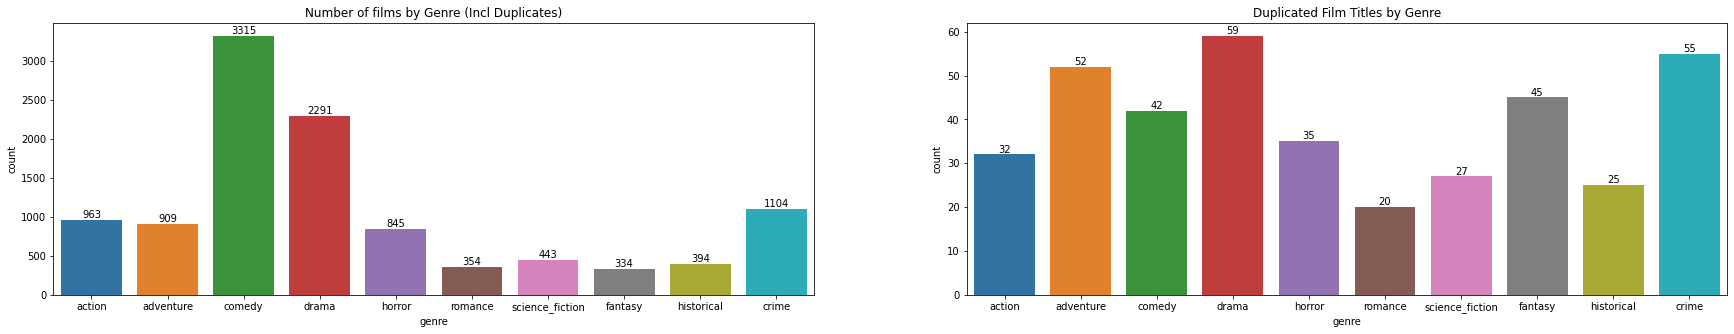

In [8]:
# Section 2(ii)
dup_film_genre = pd.DataFrame(joined_film_df_plot[joined_film_df['title'].duplicated()]['genre'])
dup_film_genre.genre = dup_film_genre.genre.astype("category")
dup_film_genre.genre = dup_film_genre.genre.cat.set_categories(films_genre)
dup_film_genre = dup_film_genre.sort_values(["genre"])
dup_film_genre.reset_index(drop=True,inplace=True)

plt.figure(figsize = (30,5))
plt.subplot(1,2,1)
plt.title("Number of films by Genre (Incl Duplicates)")

ax = sns.countplot(x = 'genre', data = joined_film_df)
abs_values = joined_film_df['genre'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

plt.subplot(1,2,2)
plt.title("Duplicated Film Titles by Genre")

ax = sns.countplot(x = 'genre', data = dup_film_genre)
abs_values = dup_film_genre['genre'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)



In [9]:
# Section 2(iii)
print(joined_film_df_plot[joined_film_df_plot['title'].duplicated()])
# Example of cross-genre film
print(joined_film_df_plot[joined_film_df_plot['title']=="Underworld (1985 film)"])

                             title      genre
228             Apocalypse Pompeii  adventure
247               Beatrice Fairfax  adventure
329              Dance Hall Racket  adventure
440      Airplane Mode (2019 film)     comedy
465    America: The Motion Picture     comedy
...                            ...        ...
10892              Sinister (film)     horror
10908    Tale of Tales (2015 film)     horror
10921       The Trollenberg Terror     horror
10923       Underworld (1985 film)     horror
10938             What Waits Below     horror

[392 rows x 2 columns]
                        title            genre
2786   Underworld (1985 film)  science_fiction
10923  Underworld (1985 film)           horror


[Text(0, 0, '2232'),
 Text(0, 0, '331'),
 Text(0, 0, '3278'),
 Text(0, 0, '418'),
 Text(0, 0, '846'),
 Text(0, 0, '805'),
 Text(0, 0, '287'),
 Text(0, 0, '1076'),
 Text(0, 0, '916'),
 Text(0, 0, '371')]

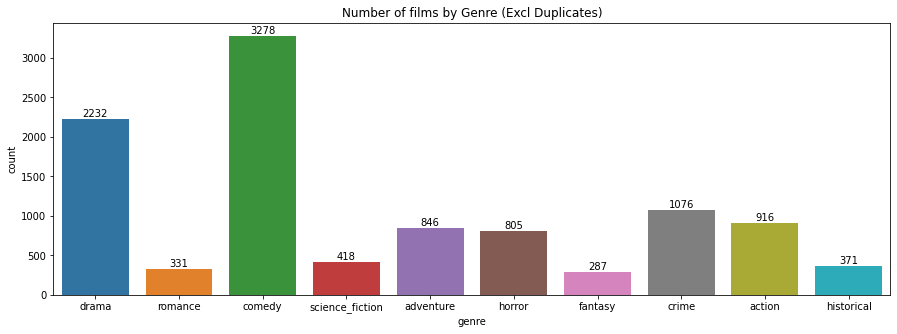

In [10]:
# Section 2(iv)
joined_film_df = joined_film_df.sample(frac=1).drop_duplicates(subset=['title'], keep='first').reset_index(drop=True)

# Plot using separate dataframe
joined_film_df_plot = joined_film_df_plot.sample(frac=1).drop_duplicates(subset=['title'], keep='first').reset_index(drop=True)
joined_film_df_plot.genre = joined_film_df_plot.genre.astype("category")
joined_film_df_plot.genre = joined_film_df_plot.genre.cat.set_categories(films_genre)
joined_film_df_plot = joined_film_df_plot.sort_values(["genre"])
plt.figure(figsize = (15,5))
plt.title("Number of films by Genre (Excl Duplicates)")

ax = sns.countplot(x = 'genre', data = joined_film_df)
abs_values = joined_film_df['genre'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

### Section 2 : Exploratory Data Analysis (Continued)
#### <font color ='green'>(v) After dropping duplicated films, there is a need to obtain a more balanced Genre distribution for the purpose of training, otherwise we might face an issue of always predicting the largest class.</font>
- First, we've identified 4 genres that have significantly lower number of films than others (fantasy, historical, romance, science_fiction). Created a temporary placeholder (temp_film_df) to store data and do not impose any treatment.
- Second, The remaining 6 genres that have significantly higher number of films are stored into a separate dataframe (temp_film_df_2). This operation is for the purpose of sampling "n" number of samples from each of the bigger genre class. In our case, we are using n=500 randomly while taking into consideration that some of these films may not have associated "plot" to be considered as an appropriate sample and will eventually have to be dropped off.
- Third, Concatenate both temp_file_df and the updated temp_file_df_2 as one dataframe (working_film_df).

[Text(0, 0, '500'),
 Text(0, 0, '500'),
 Text(0, 0, '500'),
 Text(0, 0, '500'),
 Text(0, 0, '500'),
 Text(0, 0, '326'),
 Text(0, 0, '414'),
 Text(0, 0, '290'),
 Text(0, 0, '372'),
 Text(0, 0, '500')]

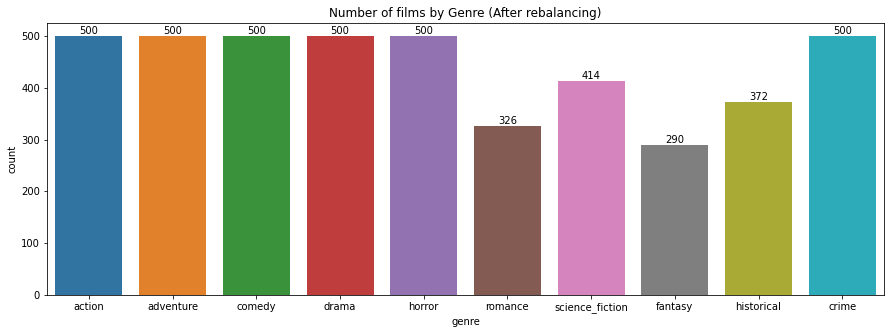

In [ ]:
#Section 2(v): WE NEED TO CREATE A EXACT SET EVERYTIME, USE SEED
#Create a place holder df for Genres with small number of films
temp_film_df = joined_film_df.loc[(joined_film_df['genre'] == 'fantasy') | (joined_film_df['genre'] == 'historical') | 
                           (joined_film_df['genre'] == 'romance') | (joined_film_df['genre'] == 'science_fiction')]

temp_film_df.reset_index(inplace = True, drop=True)

#Create a place holder df for the remaining Genres films
temp_film_df_2 = joined_film_df.loc[(joined_film_df['genre'] == 'action') | (joined_film_df['genre'] == 'adventure') | 
                           (joined_film_df['genre'] == 'comedy') | (joined_film_df['genre'] == 'crime') |
                            (joined_film_df['genre'] == 'drama') | (joined_film_df['genre'] == 'horror')]

temp_film_df_2.reset_index(inplace = True, drop=True)

#Sampling 500 films from each genre, setting random state to ensure reproductibility
temp_film_df_2 = temp_film_df_2.groupby('genre').apply(pd.DataFrame.sample, n=500, random_state=1)

#concat both temp df back together
working_film_df = pd.concat([temp_film_df,temp_film_df_2],axis=0,ignore_index=True)
working_film_df.genre = working_film_df.genre.astype("category")
working_film_df.genre = working_film_df.genre.cat.set_categories(films_genre)
working_film_df = working_film_df.sort_values(["genre"])

plt.figure(figsize = (15,5))
plt.title("Number of films by Genre (After rebalancing)")

ax = sns.countplot(x = 'genre', data = working_film_df)
abs_values = working_film_df['genre'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

### Section 2.1 : Web Scrape for film plots using wikipedia and wikipediaapi (CAUTION! it may take up to approximately 1 hour to scrape the data!)
#### <font color ='green'>(i) With the data collected previously (titles and genres), we have defined a function that will tap on wikipedia.page / wikipediaapi.Wikipedia.page to extract the section "Plot". We tried to extract via wikipedia.page, if unable to extract due to library unresolved error, we will adopt wikipediaapi.Wikipedia.page for extraction instead. There are some scenarios that may happen during the extraction:</font>
- Able to extract "Plot" via wikipedia.page (What we needed)
- Able to extract "Plot" via wikipedia.page, however, the section does not contain any texts (To be removed later)
- Unable to extract "Plot" via wikipedia.page, adopted wikipediaapi.Wikipedia.page instead and we are able to extract "Plot" (What we needed)
- Unable to extract "Plot" via wikipedia.page, adopted wikipediaapi.Wikipedia.page instead and we are able to extract "Plot", however, the section does not contain any texts (To be removed later)
- Unable to extract "Plot" via wikipedia.page, adopted wikipediaapi.Wikipedia.page instead and we are unable to extract "Plot", meaning that the section on "Plot" does not exist within the page (To be removed later)
- Error, unable to execute both wikipedia.page & wikipediaapi.Wikipedia.page (To be removed later)

#### <font color ='green'>(ii) Based on the scenarios mentioned in web scraping script section 6(i), we will analyze and subsequently remove rows where plot is:</font>
- null/na
- "Page with no Section on Plot"
- "error"
- Plots with word count < 10 to prevent situations in CNN1d where plot length is < kernel size

#### <font color ='green'>(iii) Further cleaning of dataset
- Remove punctuations for each plot

In [ ]:
# Section 2.1(i)

def film_plot_scraping(dataframe_title_col):
    '''
    params: require a dataframe 'title' column or list of titles
    return: film plots to be added to original dataframe
    '''
    film_plots = []
    duration_accumulated = 0
    wiki_wiki = wikipediaapi.Wikipedia(language = 'en', extract_format = wikipediaapi.ExtractFormat.WIKI)
    count = 0
    for title in list(dataframe_title_col):
        start_time = time.time()
        
        try:
            film_plots.append(wikipedia.page(title).section('Plot'))
            duration = time.time() - start_time
            duration_accumulated += duration
            count += 1
            print(f'{count}: using wikipedia.page | {title} | {duration:.2f} seconds.. | {duration_accumulated/60:.2f} minutes..')
        
        except:
            try:
                if "Section: Plot" in str(wiki_wiki.page(title).sections[0]):
                    film_plots.append(wiki_wiki.page(title).sections[0].text)
                    duration = time.time() - start_time
                    duration_accumulated += duration
                    count += 1
                    print(f'{count}: using wiki_wiki.page instead | {title} | {duration:.2f} seconds.. | {duration_accumulated/60:.2f} minutes..')
                else:
                    film_plots.append("Page with no Section on Plot")
                    duration = time.time() - start_time
                    duration_accumulated += duration
                    count += 1
                    print(f'{count}: page with no Section on Plot | {title} | {duration:.2f} seconds.. | {duration_accumulated/60:.2f} minutes..')
            except:
                film_plots.append('error')
                duration = time.time() - start_time
                duration_accumulated += duration
                count += 1
                print(f'{count}: error | {title} | {duration:.2f} seconds.. | {duration_accumulated/60:.2f} minutes..')

    return film_plots

# #adding column 'plot' to main dataframe
working_film_df['plot'] = film_plot_scraping(working_film_df['title'])

1: using wiki_wiki.page instead | Bulletproof (1988 film) | 0.70 seconds.. | 0.01 minutes..
2: using wikipedia.page | Damned River | 0.24 seconds.. | 0.02 minutes..
3: using wikipedia.page | Con Express | 0.24 seconds.. | 0.02 minutes..
4: using wikipedia.page | A Gentleman Roughneck | 0.24 seconds.. | 0.02 minutes..
5: using wikipedia.page | Sniper 2 | 0.25 seconds.. | 0.03 minutes..
6: using wikipedia.page | The Yellow Arm | 0.24 seconds.. | 0.03 minutes..
7: using wikipedia.page | Rogue Agent (film) | 0.23 seconds.. | 0.04 minutes..
8: using wikipedia.page | The Wall Street Whiz | 0.50 seconds.. | 0.04 minutes..
9: using wikipedia.page | Cool Change (film) | 0.25 seconds.. | 0.05 minutes..
10: using wikipedia.page | American Samurai | 0.28 seconds.. | 0.05 minutes..
11: using wikipedia.page | Avalanche (1946 film) | 0.23 seconds.. | 0.06 minutes..
12: using wikipedia.page | Call of the South Seas | 0.25 seconds.. | 0.06 minutes..
13: using wikipedia.page | Sun Valley (film) | 0.48 s

/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


114: using wiki_wiki.page instead | Nightstick (film) | 3.09 seconds.. | 0.80 minutes..
115: using wikipedia.page | Deadly Heroes | 2.77 seconds.. | 0.85 minutes..
116: using wikipedia.page | Murder Is My Business | 4.28 seconds.. | 0.92 minutes..
117: using wikipedia.page | Down 'n Dirty | 2.73 seconds.. | 0.96 minutes..
118: using wikipedia.page | Supercell (film) | 2.15 seconds.. | 1.00 minutes..
119: using wiki_wiki.page instead | Derailed (2002 film) | 0.49 seconds.. | 1.01 minutes..
120: using wikipedia.page | Final Reprisal | 0.44 seconds.. | 1.02 minutes..
121: using wikipedia.page | Flying Over Grass | 0.23 seconds.. | 1.02 minutes..
122: using wikipedia.page | King of Robbery | 0.24 seconds.. | 1.02 minutes..
123: using wikipedia.page | Striking Point | 0.24 seconds.. | 1.03 minutes..
124: using wikipedia.page | J.C. (film) | 0.23 seconds.. | 1.03 minutes..
125: using wikipedia.page | Pride of the Navy | 0.24 seconds.. | 1.04 minutes..
126: using wikipedia.page | The Eliminat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


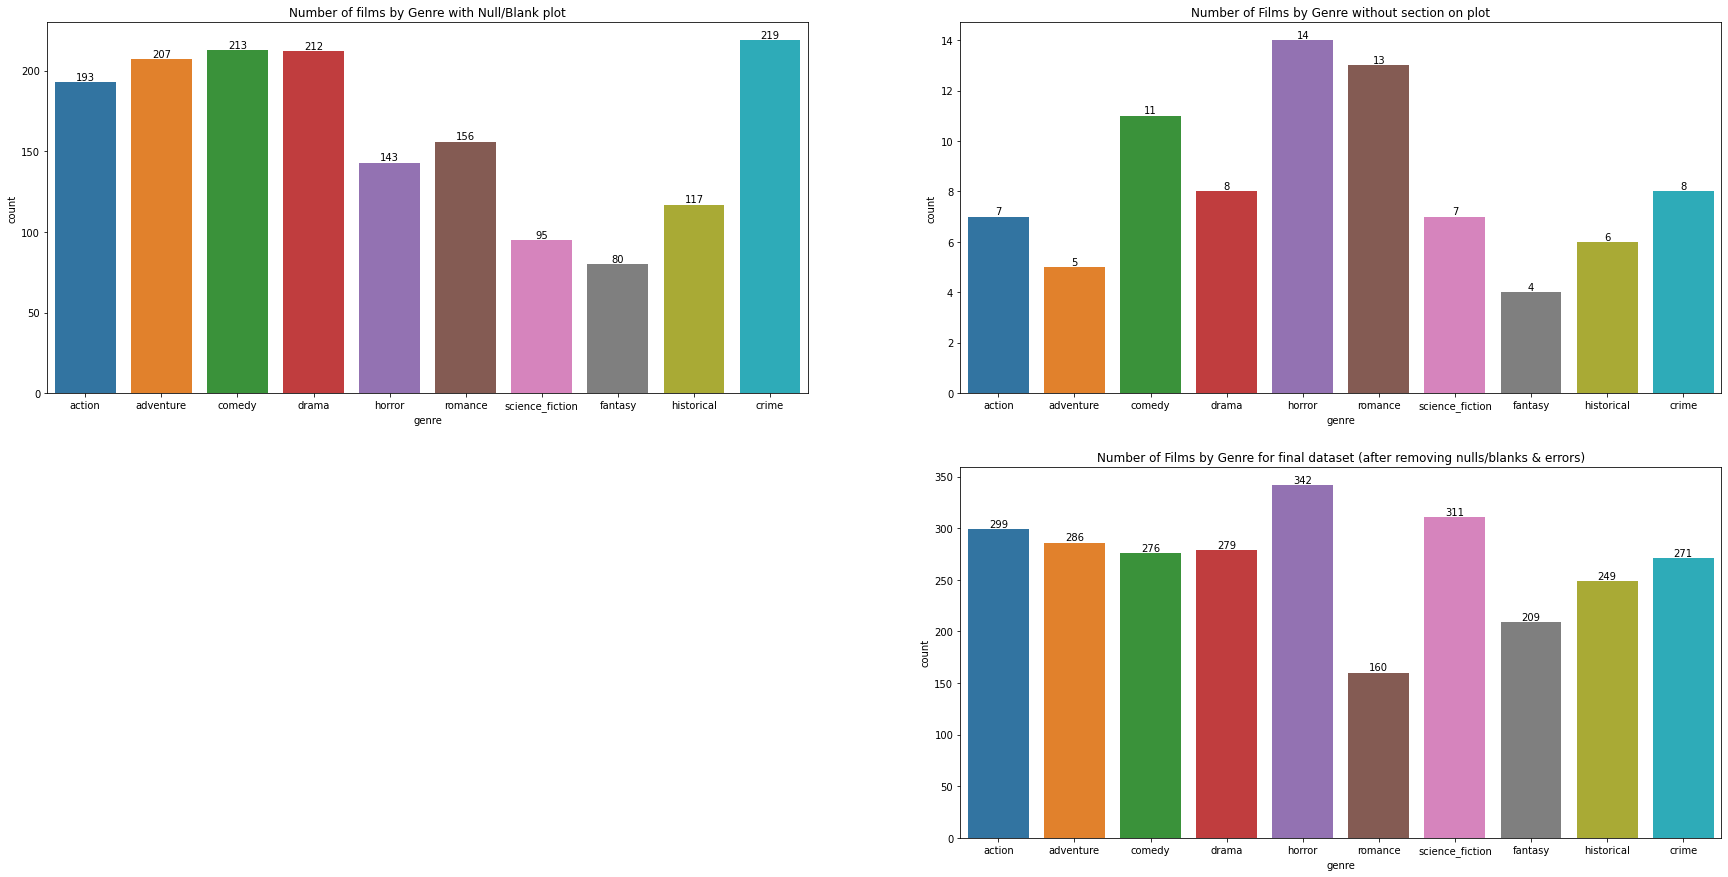

In [ ]:
# Section 2.1(ii) - 1: Page with Section on Plot but contains no text, thus null or blank
plot_null_df = working_film_df.loc[(working_film_df['plot']=="") | (working_film_df['plot'].isnull()) ]
plot_null_df['plot'] = "Null" #for plotting the null values

# Section 2.1(ii) - 2:Page with no Section on Plot
no_section_plot_df = working_film_df[working_film_df['plot'] == "Page with no Section on Plot"]

# Section 2.1(ii) - 3: Error (Unable to extract)
error_plot_df = working_film_df[working_film_df['plot'] == "error"]

# Section 2.1(ii): removal of rows mentioned above to form dataset that is useable
working_df = working_film_df.copy()
working_df = working_df[~working_df['plot'].isnull()]
working_df = working_df[working_df['plot'] != ""]
working_df = working_df[working_df['plot'] != "Page with no Section on Plot"]
working_df = working_df[working_df['plot'] != "error"]
working_df = working_df[working_df['plot'].apply(lambda x: len(x.split()) >= 10)] # To prevent failure in CNN1d if length less than kernel_size = 3
working_df.reset_index(drop=True,inplace=True)

#Commence plotting
plt.figure(figsize = (30,15))
# 1st visual
plt.subplot(2,2,1)
plt.title("Number of films by Genre with Null/Blank plot")

ax = sns.countplot(x = 'genre', data = plot_null_df) #order=plot_null_df['genre'].value_counts(ascending=False).index
abs_values = plot_null_df['genre'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

# 2nd visual
plt.subplot(2,2,2)
plt.title("Number of Films by Genre without section on plot")

ax = sns.countplot(x = 'genre', data = no_section_plot_df) #order=no_section_plot_df['genre'].value_counts(ascending=False).index
abs_values = no_section_plot_df['genre'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

# # 3rd visual -- There are no errors in this dataset, for other random_state, errors do exist.
# plt.subplot(2,2,3)
# plt.title("Number of Films by Genre with error")

# ax = sns.countplot(x = 'genre', data = error_plot_df,order=error_plot_df['genre'].value_counts(ascending=False).index)
# abs_values = error_plot_df['genre'].value_counts(ascending=False).values
# ax.bar_label(container=ax.containers[0], labels=abs_values)


# 4th visual
plt.subplot(2,2,4)
plt.title("Number of Films by Genre for final dataset (after removing nulls/blanks & errors)")

ax = sns.countplot(x = 'genre', data = working_df) #order=clean_film_df['genre'].value_counts(ascending=False).index
abs_values = working_df['genre'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

# changing genre (science_fiction) to scifi
working_df['genre'] = working_df['genre'].replace(to_replace=r'science_fiction', value='scifi')

In [ ]:
# Section 2.1(iii) Removing punctuations from plots
def remove_punctuations(dataframe_text_col):
    punctuations_removed_sentence = []
    for sentence in dataframe_text_col:
        processed_sentence = sentence.translate(str.maketrans("","",string.punctuation))
        removed_whitespaces_sentence = " ".join(processed_sentence.split())
        lower_cased_sentence = removed_whitespaces_sentence.lower()
        punctuations_removed_sentence.append(lower_cased_sentence)

    return punctuations_removed_sentence

working_df['plot'] = remove_punctuations(working_df['plot'])

## Section 2.2 : Basic linguistic analysis of movie reviews
#### <font color ='green'>(i) Compute plot's word count for each film, number of stopwords per plot and analyze by genre.</font>
- We observed that on average, the word count distribution for each genre are similar to the distributions of stopwords existing within plots

In [ ]:
# Section 2.2(i)
def stop_and_total_words_and_proportion_counter(dataframe_text_col):
    '''
    params: dataframe column / np array / list
    returns: (1) a list of elements for counts on # of stopwords in a sentence
             (2) a list of elements for counts on # of words in a sentence
             (3) a list of elements for (1)/(2) of each sentence
    '''
    total_time_taken = 0
    count_list_sw = []
    count_list_total = []
    proportion_of_stopwords = []
    count_sentence = 0
    stop_words = nltk.corpus.stopwords.words('english')
    for sentence in dataframe_text_col:
        start_time = time.time()
        tokenized = word_tokenize(sentence)
        # print(tokenized)
        count_stop_words = 0
        count_total_words = 0
        for word in tokenized:
            count_total_words +=1
            # print(F'Total word: {word} | {count_total_words}')
            if word in stop_words:
                count_stop_words +=1
                # print(f'Stop word: {word} | {count_stop_words}')
            else:
                count_stop_words = count_stop_words
        time_taken_per_sentence = time.time() - start_time
        total_time_taken += time_taken_per_sentence
        count_list_sw.append(count_stop_words)
        count_list_total.append(count_total_words)
        proportion_of_stopwords.append(count_stop_words/count_total_words)
        count_sentence +=1
        if count_sentence % 100 == 0:
            print(f'#SENTENCE READ: {count_sentence} | time taken per sentence: {time_taken_per_sentence:.2f} second(s) | overall time taken: {total_time_taken/60:.2f} minute(s)')
    return count_list_sw , count_list_total , proportion_of_stopwords

In [ ]:
# Section 2.2(i): Computing stopwords count, plot length, and proportion of stopwords to plot length for each plot
working_df['stopwords_count'], working_df['word_count'], working_df['proportion_of_stopwords_to_wordcount'] = stop_and_total_words_and_proportion_counter(working_df['plot'])
working_df['proportion_of_stopwords_to_wordcount'] = working_df['proportion_of_stopwords_to_wordcount'].map('{:,.3f}'.format)
working_df['proportion_of_stopwords_to_wordcount'] = working_df["proportion_of_stopwords_to_wordcount"].apply(lambda x: float(x))

#SENTENCE READ: 100 | time taken per sentence: 0.01 second(s) | overall time taken: 0.00 minute(s)
#SENTENCE READ: 200 | time taken per sentence: 0.00 second(s) | overall time taken: 0.01 minute(s)
#SENTENCE READ: 300 | time taken per sentence: 0.00 second(s) | overall time taken: 0.01 minute(s)
#SENTENCE READ: 400 | time taken per sentence: 0.00 second(s) | overall time taken: 0.01 minute(s)
#SENTENCE READ: 500 | time taken per sentence: 0.00 second(s) | overall time taken: 0.01 minute(s)
#SENTENCE READ: 600 | time taken per sentence: 0.00 second(s) | overall time taken: 0.02 minute(s)
#SENTENCE READ: 700 | time taken per sentence: 0.00 second(s) | overall time taken: 0.02 minute(s)
#SENTENCE READ: 800 | time taken per sentence: 0.00 second(s) | overall time taken: 0.02 minute(s)
#SENTENCE READ: 900 | time taken per sentence: 0.00 second(s) | overall time taken: 0.03 minute(s)
#SENTENCE READ: 1000 | time taken per sentence: 0.00 second(s) | overall time taken: 0.03 minute(s)
#SENTENCE

<AxesSubplot:title={'center':'Box plot analysis of Genre by stopwords count'}, xlabel='stopwords_count', ylabel='genre'>

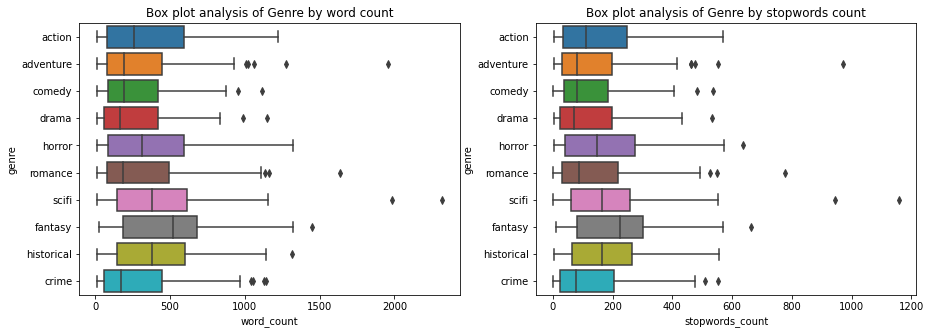

In [ ]:
#Section 2.2(i)
# 1st visual: distribution of genre by plot_length
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Box plot analysis of Genre by word count')
sns.boxplot(x = 'word_count', y='genre', data=working_df)

# 2nd visual: distribution of genre by stopwords_count
plt.subplot(1,2,2)
plt.title('Box plot analysis of Genre by stopwords count')
sns.boxplot(x = 'stopwords_count', y='genre', data=working_df)

## Section 2.3 : Data storage and trial
#### <font color ='green'>(i) Create final dataframe to be consumed for model development and testing (df).  
- Exported 10 files (one csv file for each class)
- Zipped the 10 files as one for consumption (cleaning, model development...)

#### <font color ='green'>(ii) Tests that we are able to read data from google drive and load into pandas dataframe.

[Text(0, 0, '299'),
 Text(0, 0, '286'),
 Text(0, 0, '276'),
 Text(0, 0, '279'),
 Text(0, 0, '342'),
 Text(0, 0, '160'),
 Text(0, 0, '311'),
 Text(0, 0, '209'),
 Text(0, 0, '249'),
 Text(0, 0, '271')]

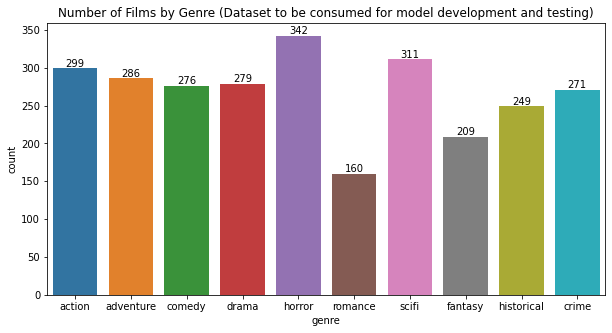

In [ ]:
# Section 2.3(i) : Dataset to be consumed for model training and testing(df)
df = working_df.copy()
df = df[['genre','plot']]

plt.figure(figsize = (10,5))
plt.title("Number of Films by Genre (Dataset to be consumed for model development and testing)")
ax = sns.countplot(x = 'genre', data = df) #order=clean_film_df['genre'].value_counts(ascending=False).index
abs_values = df['genre'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

In [ ]:
# Section 2.3(i)
FILMS_GENRE = [
    "action",
    "adventure",
    "comedy",
    "drama",
    "horror",
    "romance",
    "scifi", # science fiction
    "fantasy",
    "historical",
    "crime"
]

In [ ]:
# Section 2.3(i): Extraction of files into zipped folder (Google Colab)
if not os.path.isdir(f"/content/gdrive/My Drive/CS5242_Project_Data"):

# if CS5242_Project_Data folder is not present, create it
    os.makedirs(f"/content/gdrive/My Drive/CS5242_Project_Data")

for genre in FILMS_GENRE:
    if not os.path.isdir(f"/content/gdrive/My Drive/CS5242_Project_Data/{genre}"):

        # if genre folder is not present, create it
        os.makedirs(f"/content/gdrive/My Drive/CS5242_Project_Data/{genre}")

for genre in FILMS_GENRE:
    df[df['genre']==genre].to_csv(f"/content/gdrive/My Drive/CS5242_Project_Data/{genre}/{genre}_films.csv",index=False)

file_paths_zip = []
for genre in os.listdir('/content/gdrive/MyDrive/CS5242_Project_Data'):
  for root, directories, files in os.walk(f'/content/gdrive/MyDrive/CS5242_Project_Data/{genre}'):
    for filename in files:
      filepath = os.path.join(root,filename)
      file_paths_zip.append(filepath)

with ZipFile('/content/gdrive/MyDrive/data_full3.zip','w') as zip:
    for file in file_paths_zip:
        zip.write(file)

In [ ]:
# Section 2.3(ii): Test for downloading data directly from file location instead of re-running the code above
!gdown 10fAkL5gOYjG0WcNIwZnZ1X9_n8pciT19
path = "/content/data_full3.zip"

Downloading...
From: https://drive.google.com/uc?id=10fAkL5gOYjG0WcNIwZnZ1X9_n8pciT19
To: /content/data_full3.zip
100% 5.15M/5.15M [00:00<00:00, 231MB/s]


In [ ]:
 # Section 2.3(ii): Test for loading data from zip into pandas dataframe
initial_df = pd.DataFrame()
with zipfile.ZipFile('/content/data_full3.zip') as z:
  for name in z.namelist():
    if name.endswith(".csv"):
      print(f'Loading data from {name}...')
      x = pd.read_csv(z.open(name))
      print(f'Loading completed from {name}...')
      initial_df = pd.concat([initial_df,x[['genre','plot']]],axis=0,ignore_index=True)
  print("Dataframe (df) ready to be used!")

initial_df

Loading data from content/gdrive/MyDrive/CS5242_Project_Data/action/action_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data/action/action_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data/adventure/adventure_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data/adventure/adventure_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data/comedy/comedy_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data/comedy/comedy_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data/drama/drama_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data/drama/drama_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data/horror/horror_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data/horror/horror_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data/romance/romance_films.csv.

,genre,plot
0,action,frank vega is a decorated vietnam war veteran ...
1,action,journalist matt nashs dylan walsh investigatio...
2,action,in the midtolate 1960s three young men leave t...
3,action,po sing the youngest son of chinese triad boss...
4,action,clay santell audie murphy has his horse stolen...
...,...,...
2677,crime,a mexican newspaperman wages a oneman war agai...
2678,crime,larry crain peter cookson a medical student on...
2679,crime,a texas ranger samantha payne opens up a fifte...
2680,crime,billy dempsey is a well dressed bank robber wh...


## Section 2.4 : Generate Second Dataset with more films per genre
#### <font color ='green'>(i) Creating second dataset with more films per genre in case there is a need to upsample for model development.

#### <font color ='green'>(ii) Create final dataframe (2) to be consumed for model development and testing.  
- Exported 10 files (one csv file for each class)
- Zipped the 10 files as one for consumption (cleaning, model development...)

#### <font color ='green'>(iii) Tests that we are able to read data from google drive and load into pandas dataframe.

[Text(0, 0, '800'),
 Text(0, 0, '800'),
 Text(0, 0, '800'),
 Text(0, 0, '800'),
 Text(0, 0, '800'),
 Text(0, 0, '328'),
 Text(0, 0, '420'),
 Text(0, 0, '288'),
 Text(0, 0, '370'),
 Text(0, 0, '800')]

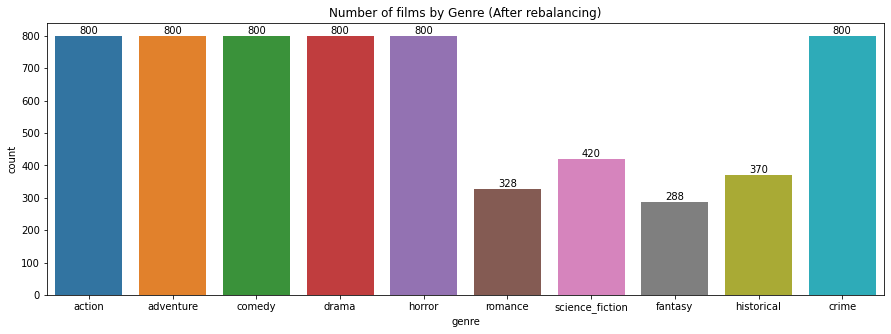

In [ ]:
# SECOND DATASET
#Section 2.4(i): WE NEED TO CREATE A EXACT SET EVERYTIME, USE SEED
#Create a place holder df for Genres with small number of films
temp_film_df_3 = joined_film_df.loc[(joined_film_df['genre'] == 'fantasy') | (joined_film_df['genre'] == 'historical') | 
                           (joined_film_df['genre'] == 'romance') | (joined_film_df['genre'] == 'science_fiction')]

temp_film_df_3.reset_index(inplace = True, drop=True)

#Create a place holder df for the remaining Genres films
temp_film_df_4 = joined_film_df.loc[(joined_film_df['genre'] == 'action') | (joined_film_df['genre'] == 'adventure') | 
                           (joined_film_df['genre'] == 'comedy') | (joined_film_df['genre'] == 'crime') |
                            (joined_film_df['genre'] == 'drama') | (joined_film_df['genre'] == 'horror')]

temp_film_df_4.reset_index(inplace = True, drop=True)

#Sampling 500 films from each genre, setting random state to ensure reproductibility
temp_film_df_4 = temp_film_df_4.groupby('genre').apply(pd.DataFrame.sample, n=800, random_state=1)

#concat both temp df back together
working_film_df_2 = pd.concat([temp_film_df_3,temp_film_df_4],axis=0,ignore_index=True)
working_film_df_2.genre = working_film_df_2.genre.astype("category")
working_film_df_2.genre = working_film_df_2.genre.cat.set_categories(films_genre)
working_film_df_2 = working_film_df_2.sort_values(["genre"])

plt.figure(figsize = (15,5))
plt.title("Number of films by Genre (After rebalancing)")

ax = sns.countplot(x = 'genre', data = working_film_df_2)
abs_values = working_film_df_2['genre'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

In [ ]:
# Section 2.4(i) : adding column 'plot' to second dataset's dataframe
working_film_df_2['plot'] = film_plot_scraping(working_film_df_2['title'])

1: using wikipedia.page | Intrepid (film) | 0.46 seconds.. | 0.01 minutes..
2: using wikipedia.page | Skyfire (film) | 0.47 seconds.. | 0.02 minutes..
3: using wikipedia.page | Fight Valley | 0.47 seconds.. | 0.02 minutes..
4: using wikipedia.page | Dangers of the Canadian Mounted | 0.53 seconds.. | 0.03 minutes..
5: using wikipedia.page | Money Plane | 0.47 seconds.. | 0.04 minutes..
6: using wikipedia.page | Sherlock Holmes (2009 film) | 0.49 seconds.. | 0.05 minutes..
7: using wikipedia.page | Killer's Romance | 1.04 seconds.. | 0.07 minutes..
8: using wikipedia.page | Hong Kong Bronx | 0.47 seconds.. | 0.07 minutes..
9: using wikipedia.page | The Lost Bladesman | 0.43 seconds.. | 0.08 minutes..
10: using wikipedia.page | The Bravest Revenge | 1.12 seconds.. | 0.10 minutes..
11: using wikipedia.page | Street Warrior | 0.49 seconds.. | 0.11 minutes..
12: page with no Section on Plot | White Elephant (2022 film) | 0.46 seconds.. | 0.11 minutes..
13: using wikipedia.page | The Treasure

/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Streaming output truncated to the last 5000 lines.
1207: using wiki_wiki.page instead | White Witch Doctor | 0.45 seconds.. | 13.19 minutes..
1208: using wikipedia.page | Mr. Forbush and the Penguins | 0.48 seconds.. | 13.20 minutes..
1209: using wikipedia.page | The Slave Market (film) | 0.56 seconds.. | 13.21 minutes..
1210: using wikipedia.page | Tom Mix in Arabia | 0.58 seconds.. | 13.22 minutes..
1211: using wikipedia.page | The Big Gamble (1961 film) | 0.50 seconds.. | 13.23 minutes..
1212: using wikipedia.page | The Torrent (1921 film) | 0.47 seconds.. | 13.24 minutes..
1213: using wikipedia.page | China Corsair | 0.49 seconds.. | 13.24 minutes..
1214: using wikipedia.page | The Seekers (1954 film) | 0.94 seconds.. | 13.26 minutes..
1215: using wikipedia.page | The Big Gusher | 0.45 seconds.. | 13.27 minutes..
1216: using wikipedia.page | The Adventures of Hal 5 | 0.50 seconds.. | 13.28 minutes..
1217: using wikipedia.page | Fury (1923 film) | 0.96 seconds.. | 13.29 minutes..
12

In [ ]:
# Section 2.4(i): removal of rows mentioned above to form dataset that is useable
working_df_2 = working_film_df_2.copy()
working_df_2 = working_df_2[~working_df_2['plot'].isnull()]
working_df_2 = working_df_2[working_df_2['plot'] != ""]
working_df_2 = working_df_2[working_df_2['plot'] != "Page with no Section on Plot"]
working_df_2 = working_df_2[working_df_2['plot'] != "error"]
working_df_2 = working_df_2[working_df_2['plot'].apply(lambda x: len(x.split()) >= 10)] # To prevent failure in CNN1d if length less than kernel_size = 3

# changing genre (science_fiction) to scifi
working_df_2['genre'] = working_df_2['genre'].replace(to_replace=r'science_fiction', value='scifi')
working_df_2.reset_index(drop=True,inplace=True)

[Text(0, 0, '484'),
 Text(0, 0, '467'),
 Text(0, 0, '462'),
 Text(0, 0, '434'),
 Text(0, 0, '561'),
 Text(0, 0, '156'),
 Text(0, 0, '316'),
 Text(0, 0, '206'),
 Text(0, 0, '246'),
 Text(0, 0, '425')]

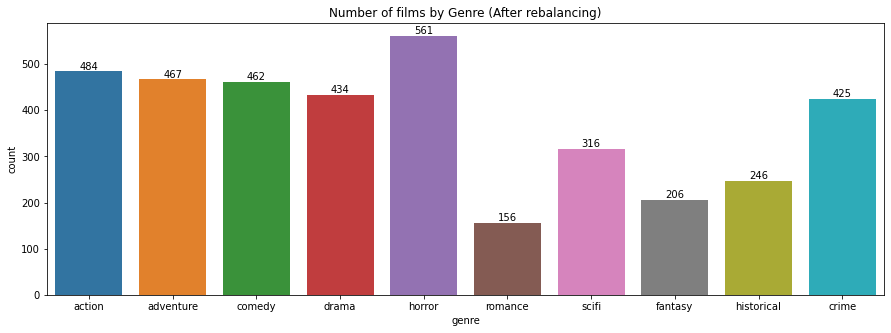

In [ ]:
# Section 2.4(i): Removing punctuations
working_df_2['plot'] = remove_punctuations(working_df_2['plot'])

plt.figure(figsize = (15,5))
plt.title("Number of films by Genre (After rebalancing)")

ax = sns.countplot(x = 'genre', data = working_df_2)
abs_values = working_df_2['genre'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

In [ ]:
# Section 2.4(ii): Extraction of files into zipped folder (Google Colab)
if not os.path.isdir(f"/content/gdrive/My Drive/CS5242_Project_Data_2"):

# if CS5242_Project_Data folder is not present, create it
    os.makedirs(f"/content/gdrive/My Drive/CS5242_Project_Data_2")

for genre in FILMS_GENRE:
    if not os.path.isdir(f"/content/gdrive/My Drive/CS5242_Project_Data_2/{genre}"):

        # if genre folder is not present, create it
        os.makedirs(f"/content/gdrive/My Drive/CS5242_Project_Data_2/{genre}")

for genre in FILMS_GENRE:
    working_df_2[working_df_2['genre']==genre].to_csv(f"/content/gdrive/My Drive/CS5242_Project_Data_2/{genre}/{genre}_films.csv",index=False)

file_paths_zip = []
for genre in os.listdir('/content/gdrive/MyDrive/CS5242_Project_Data_2'):
  for root, directories, files in os.walk(f'/content/gdrive/MyDrive/CS5242_Project_Data_2/{genre}'):
    for filename in files:
      filepath = os.path.join(root,filename)
      file_paths_zip.append(filepath)

with ZipFile('/content/gdrive/MyDrive/data_full4.zip','w') as zip:
    for file in file_paths_zip:
        zip.write(file)

In [ ]:
# Section 2.4(iii): Test for downloading data directly from file location instead of re-running the code above
!gdown 1dhTF48AKpPBEq0ZeSstOSsS17A7ktmzl
path = "/content/data_full4.zip"

Downloading...
From: https://drive.google.com/uc?id=1dhTF48AKpPBEq0ZeSstOSsS17A7ktmzl
To: /content/data_full4.zip
100% 7.18M/7.18M [00:00<00:00, 186MB/s]


In [ ]:
 # Section 2.4(iii): Test for loading data from zip into pandas dataframe
initial_df_2 = pd.DataFrame()
with zipfile.ZipFile('/content/data_full4.zip') as z:
  for name in z.namelist():
    if name.endswith(".csv"):
      print(f'Loading data from {name}...')
      x = pd.read_csv(z.open(name))
      print(f'Loading completed from {name}...')
      initial_df_2 = pd.concat([initial_df_2,x[['genre','plot']]],axis=0,ignore_index=True)
  print("Dataframe (df) ready to be used!")

initial_df_2

Loading data from content/gdrive/MyDrive/CS5242_Project_Data_2/action/action_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data_2/action/action_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data_2/adventure/adventure_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data_2/adventure/adventure_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data_2/comedy/comedy_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data_2/comedy/comedy_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data_2/drama/drama_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data_2/drama/drama_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data_2/horror/horror_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data_2/horror/horror_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data_2/roma

,genre,plot
0,action,twentytwo year old tori coro gets involved in ...
1,action,a criminal gang discovers a genghis khan treas...
2,action,in 1890 london private detective sherlock holm...
3,action,jenny is a student studying abroad in london l...
4,action,neil is a former triad boss who has just been ...
...,...,...
3752,crime,journalist rex banner peter reynolds with the ...
3753,crime,smalltown girl jean lowell is about to wed far...
3754,crime,as recorded in a film magazine maggie the daug...
3755,crime,two women with bad taste in men are thrown tog...
